# EE4416: Assignment 3
## Fine-Tuning Pre-trained Language Model (PLM) for Sentiment Analysis

In this assignment, students are required to fine-tune a pre-trained language model like BERT for sentiment analysis using the IMDB (Internet Movie Database) dataset. The IMDB dataset is commonly used for sentiment analysis in natural language processing. It contains a large collection of movie reviews, each labeled as positive or negative based on the sentiment expressed in the text.

<img src='https://media.geeksforgeeks.org/wp-content/uploads/20230802120409/Single-Sentence-Classification-Task.png'>

To complete the assignment, students can refer to a demo Colab notebook that demonstrates fine-tuning BERT for spam classification. The notebook can be accessed at the following URL:

* https://colab.research.google.com/drive/1yxLJzohAIg5Xma5i7nTP4b_9ZtFp_YAy#scrollTo=D0FoX3-31HKg

However, instead of using the spam dataset, students need to use the IMDB dataset for training the model and evaluating its performance based on validation accuracy. In addition to BERT, students are allowed to use other variants of BERT such as DistilBERT, RoBERTa, as well as encoder-decoder models like BART and T5.

The evaluation of the model will be based on validation accuracy of the IMDB dataset. The marking scheme is as follows:
*	≥80% accuracy: 10 marks using BERT or other PLMs
*	≥84% accuracy: 20 marks using BERT or other PLMs
*	≥88% accuracy: 30 marks using BERT or other PLMs
*	10 marks using non-BERT model such as RoBERTa, DisBERT, T5, etc.
*	10 marks will be awarded for the coding style of your Jupyter notebook and the quality of your summary and analysis of the model.

Your Jupyter notebook should include a written summary and analysis of your model architecture, training procedure, experiments, results, and conclusions for assessment. The data set must be divided into a training set (80%) and a validation set (20%) without shuffling. Discuss what techniques worked well and how you improved upon the baseline model. Include relevant visualizations.

The top 10 highest accuracy models will each receive an additional 10 marks. In case of a tie, preference will be given to models with fewer parameters and/or lower FLOPs.

Submit a zip file that consists of pdf file of your answers of Section A and the Jupyter notebook file of Section B to the EE5438 Assignment 3 on CASVAS with following file name format:

*	Filename format : Assignment03_StudentName_StudentID.zip
*	Filename example: Assignment03_Chen_Hoi_501234567.zip


**References**

- https://www.youtube.com/watch?v=_eSGWNqKeeY





In [2]:
import torch
import pickle
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BartTokenizer, BartForSequenceClassification
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange
import random

## Load the Dataset

The following cells will download the IMDB movie review dataset (http://ai.stanford.edu/~amaas/data/sentiment/) for positive-negative sentiment classification in as CSV-formatted file:

In [3]:
df = pd.read_csv('movie_data.csv')
print(len(df))
df.head()

50000


,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


<Axes: xlabel='sentiment'>

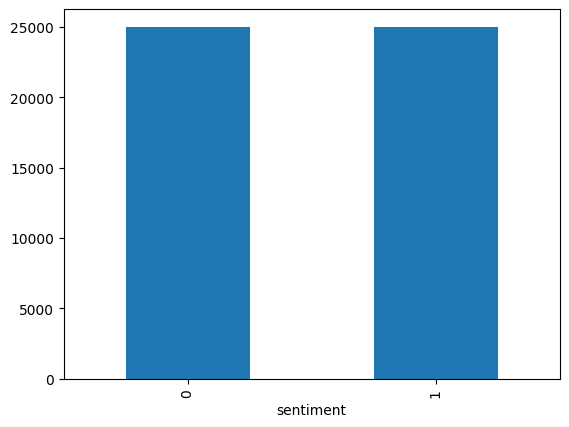

In [4]:
df.groupby(['sentiment']).size().plot.bar()

In [5]:
text = df.review.values
labels = df.sentiment.values
print(text[652])
print(labels[652])

Like a lot of people, I loved the original; "American Graffiti" was one of the great movies of the 70s. The sequel, "More American Graffiti" is a horrible, depressing mess of a movie. It wasn't funny, the wide-eyed, likable characters had become cynical and jaded, and the stories were contrived (such as "Laurie's" character having another brother because Richard Dreyfuss didn't do the sequel and "Terry the Toad" and "Pharaoh Joe" somehow managing to serve together in Vietnam). They even have a police officer by the name of "Falfa" (Harrison Ford's character in the original) who makes a "cameo". He doesn't even look like Harrison Ford, who was way too big a star by 1979 to even bother with this garbage.<br /><br />The operative word here is "funny". This movie isn't even amusing. Debbie (Candy Clark) is a stripper mixed in with a bunch of dope spoking hippies and trying to bail her dealer boyfriend out of jail; Steve and Laurie (Ron Howard and Cindy Williams), the lovebirds in the origi

To complete the assignment 3, students can refer to a demo Colab notebook that demonstrates fine-tuning BERT for spam classification. *The data set must be divided into a training set (80%) and a validation set (20%) without shuffling.* The notebook can be accessed at the following URL:

- https://colab.research.google.com/drive/1yxLJzohAIg5Xma5i7nTP4b_9ZtFp_YAy#scrollTo=D0FoX3-31HKg


## Download BartTokenizer

In [6]:
tokenizer = BartTokenizer.from_pretrained(
    'facebook/bart-base',
    do_lower_case = True
    )

There are 50265 words in vocabulary

In [7]:
tokenizer.vocab_size

50265

Tokens with Token ID

In [8]:
def print_rand_sentence():
  '''Displays the tokens and respective IDs of a random text sample'''
  index = random.randint(0, len(text)-1)
  table = np.array([tokenizer.tokenize(text[index]),
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
  print(tabulate(table,
                headers = ['Tokens', 'Token IDs'],
                tablefmt = 'fancy_grid'))

print_rand_sentence()

╒══════════════╤═════════════╕
│ Tokens       │   Token IDs │
╞══════════════╪═════════════╡
│ I            │         100 │
├──────────────┼─────────────┤
│ Ġreally      │         269 │
├──────────────┼─────────────┤
│ Ġthought     │         802 │
├──────────────┼─────────────┤
│ Ġthat        │          14 │
├──────────────┼─────────────┤
│ Ġthis        │          42 │
├──────────────┼─────────────┤
│ Ġmovie       │        1569 │
├──────────────┼─────────────┤
│ Ġwas         │          21 │
├──────────────┼─────────────┤
│ Ġsuperb      │       11415 │
├──────────────┼─────────────┤
│ .            │           4 │
├──────────────┼─────────────┤
│ ĠNot         │        1491 │
├──────────────┼─────────────┤
│ Ġonly        │         129 │
├──────────────┼─────────────┤
│ Ġis          │          16 │
├──────────────┼─────────────┤
│ Ġthe         │           5 │
├──────────────┼─────────────┤
│ Ġhistory     │         750 │
├──────────────┼─────────────┤
│ Ġcorrect     │        4577 │
├───────

## Pre-processing input
<p>BART model use more noising than BART model
<p>The noising contain: </p>
<img src = 'https://miro.medium.com/v2/resize:fit:828/format:webp/1*SxfY1s5AgxyXAoA8k0JqSA.png'>


In [9]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 512,
                        padding='max_length',
                        truncation = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )

for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids'])
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

We can also verify the output of tokenizer.encode_plus by inspecting tokens, their IDs and the attention mask for random text samples as follows:

In [10]:
print(token_id[0])
print(token_id[1])
print(token_id[2])
print(token_id[10].size())

def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

tensor([    0,  1121, 15524,     6,     5,  7044, 15281,   256,  4325,   607,
           36,   448,  7165,   324,  7569,    43,  3136,     7,     5,   239,
           12,  4684,   443,     9, 17046, 12050,     6, 28164,     6,  6520,
            4,   374,     5, 12830, 15276,  4172,     6, 15330,     9,  8789,
            6,    79,    21,  9694,    11,     5, 12284,     9,    69,   790,
            8,    69,  1900,  2442, 31787,     4, 10692,    12,  7109,   107,
          423,     6,     5,  3331,  1190,   274,  2957,   338,   397,    36,
        41055,  4448,  5270,   238,    54,    16,    10,   320,  5168, 14104,
           14,    34,  4491,    11, 19846,    13, 35059,    11,   384,     4,
          863,     4,  8677,  1500,     8,  1410,     7, 10604,     6, 11703,
            7,  4830,     5,   403,    19,    39,  1784,  3259, 25812,    36,
        19843,  5275,    43,    19,     5,  3508,     9,  2410,    10,  1040,
            4,    20,  8803,  9316,  9856,     8,   109,    45, 

## Split database
sperate the database to 80% training set and 20% validation set

In [12]:
val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    random_state=0,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx],
                          attention_masks[train_idx],
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx],
                        attention_masks[val_idx],
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

## Fine-tune Model functions

In [13]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

## Load BART model

In [14]:
# Load the BartForSequenceClassification model
model = BartForSequenceClassification.from_pretrained(
    'facebook/bart-base',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)
#summary(model,input_size=(1,32), dtypes=['torch.IntTensor']) 

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Set optimizer

In [15]:
# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(),
                              lr = 2e-5,
                              eps = 1e-08
                              )

## Check run environment

In [16]:
# Run on GPU
model.cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

create a folder to save the models

In [17]:
!mkdir Model

A subdirectory or file Model already exists.


## Training and calculate accuracy

In [19]:
epochs = 2

for loop in trange(epochs, desc = 'Epoch'):

    # ========== Training ==========

    # Set model to training mode
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids,
                             attention_mask = b_input_mask,
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids,
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)
    
    # Save the model at the end of each epoch
    with open("Model/BartforSC_model_{}.pth".format(loop), "wb") as f:
        model.eval()
        pickle.dump(model, f)
        model.train()

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')


Epoch:  50%|█████     | 1/2 [23:27<23:27, 1407.23s/it]


	 - Train loss: 0.1288
	 - Validation Accuracy: 0.9522
	 - Validation Precision: 0.9524
	 - Validation Recall: 0.9540
	 - Validation Specificity: 0.9516



Epoch: 100%|██████████| 2/2 [46:55<00:00, 1407.66s/it]


	 - Train loss: 0.0921
	 - Validation Accuracy: 0.9492
	 - Validation Precision: 0.9399
	 - Validation Recall: 0.9616
	 - Validation Specificity: 0.9377



## Performance showcase

using new reviews from Rotten Tomatoes, capture from Dune: Part Two audience reviews

In [28]:
# new reviews from Rotten Tomatoes, capture from Dune: Part Two audience reviews
review = ["Very dark. I love the first one, and was so excited for part two but it just seem to be super dark to me.",
          "Not the type of movie that I was expecting for my first date. Not the kinda movie I would watch on a first date.",
          "Long, boring, music was oppressively loud .",
          "Long movie at 2 hours and 46 minutes but it moved very fast. Keeps you interested the whole way. Great visuals, story, and sound. Best movie I have seen in a while. Go see it. It wont disappoint you.",
          "Very close to the book, which is a long in-depth story. Dramatic scenes and very real characters portrayed throughout."]

best_epoch = 1

for new_sentence in review:
  # We need Token IDs and Attention Mask for inference on the new sentence
  test_ids = []
  test_attention_mask = []

  # Apply the tokenizer
  encoding = preprocessing(new_sentence, tokenizer)

  with open(f"Model/BartforSC_model_{best_epoch}.pth","rb") as f:
      model=pickle.load(f)

  # Extract IDs and Attention Mask
  test_ids.append(encoding['input_ids'])
  test_attention_mask.append(encoding['attention_mask'])
  test_ids = torch.cat(test_ids, dim = 0)
  test_attention_mask = torch.cat(test_attention_mask, dim = 0)

  # Forward pass, calculate logit predictions
  with torch.no_grad():
    output = model(test_ids.to(device), attention_mask = test_attention_mask.to(device))

  prediction = 'positive' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'negative'

  print('Input Sentence: ', new_sentence)
  print('Predicted Class: ', prediction)

Input Sentence:  Very dark. I love the first one, and was so excited for part two but it just seem to be super dark to me.
Predicted Class:  positive
Input Sentence:  Not the type of movie that I was expecting for my first date. Not the kinda movie I would watch on a first date.
Predicted Class:  negative
Input Sentence:  Long, boring, music was oppressively loud .
Predicted Class:  negative
Input Sentence:  Long movie at 2 hours and 46 minutes but it moved very fast. Keeps you interested the whole way. Great visuals, story, and sound. Best movie I have seen in a while. Go see it. It wont disappoint you.
Predicted Class:  positive
Input Sentence:  Very close to the book, which is a long in-depth story. Dramatic scenes and very real characters portrayed throughout.
Predicted Class:  positive


## Summary
<p>In this sentiment analysis task, I use <b>BART model</b> rather than BERT model, and obtain a <b>95.22%</b> of Validation accracy on IMDB database </p>
<p>As the sentences in IMDB database is longer than the database used in example, so i changed the maximum length of token to 512. larger token size can make sure all the words in sentence is well tokenized and contain all information.</p>
<p>the batch size is 16, it is recommanded. Small batch size can improve the generalizaiton performance.</p>
<p>the learning rate is set to 2e-5, it is recommanded and it is the best choice after i tried other learning rate. No changes on eps</p>
<p>After those setting and run it, I set 2 epoches, and the first one is already the best one. 95.22% accuracy </p>
<p>Possibly due to the more noising added and the encoder-decoder full structure, the performance is even higher than bert. I got 94.14% accuracy in using BERT model, but BART can obtain 95.22%. BART and BERT model is quite similar in encoder part, so i do not need to modify a lot of the example code and can obtain a higher performance, this is a reson why i choose BART model</p>
<p>In conclusion, the performance of BART model in this task is good, and I learn that how fine-tuning works and useful :></p>